### Simple Meaning of "Chain"
A **chain** means **connecting multiple steps together so they run one after another** to complete a task.

In LangGraph or LangChain, a **chain is like a workflow**. Each step can be:
✔️ A function
✔️ A tool
✔️ An LLM call
✔️ Or some logic

All steps are **connected in order** like links in a chain.

---

### Example in LangGraph

In your notebook, the chain is:

1. Start a conversation (`start_chat`)
2. Send message to LLM (`chatbot`)
3. If needed, call tools
4. End

All these steps are **connected**. That connection is called a **chain**.

---

### One-Line Definition

> **A chain is a sequence of connected operations that run step by step to complete a task.**


In [166]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


## How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

### Why do we use `AIMessage` and `HumanMessage`?

In LangChain and LangGraph, when we build AI applications like chatbots or AI agents, we need to **store and pass conversations** between the user and the AI.

### Why not just use plain text?

Because later, LangGraph **needs structured data** to build workflows.
Every message have these important components must include:

* **role** → AI or Human?
* **content** → actual text
* **name** → optional sender name
* **metadata** → future useful info

This structure helps AI reason better and tools to understand who said what.


| Why needed?                 | Because LangGraph uses messages inside **graph state** to track conversations |

---


# Example

In [167]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Furqan"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Furqan"))

for message in messages:
    message.pretty_print()



================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Furqan

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Furqan

I want to learn python programming language


In [168]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.1-8b-instant")
result=llm.invoke(messages)

In [169]:
result.response_metadata

{'token_usage': {'completion_tokens': 574,
  'prompt_tokens': 76,
  'total_tokens': 650,
  'completion_time': 0.69340351,
  'prompt_time': 0.004057494,
  'queue_time': 0.048622856,
  'total_time': 0.697461004},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_ab04adca7d',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

| Key                 | Meaning                               |
| ------------------- | ------------------------------------- |
| `prompt_tokens`     | Tokens from our conversation history  |
| `completion_tokens` | Tokens generated by the model         |
| `total_tokens`      | Total tokens used (this affects cost) |
| `completion_time`   | Time taken to respond                 |
| `model_name`        | Model used                            |
| `finish_reason`     | Why the response stopped              |


from the Example above AIMessage and HumanMessage details/metadata through result.response_metadata

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

This is a simple function that adds two numbers.
It takes two integers a and b and returns their sum.

In [170]:
def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [171]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001B526EDAC50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B525AB55D0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

This connects the function add to the language model so it can use the tool during conversation.

Before this: AI can only chat.

After this: AI can calculate using our function.

✅ Now the AI has a new skill → addition 💪

In [172]:
### Binding tool with llm

llm_with_tools=llm.bind_tools([add])

tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="Furqan")])

Now we ask the AI:

"What is 2 plus 2"

Since this is a math question, the model will not just answer randomly—it will detect that it needs the add tool and prepare a tool call request.

In [173]:
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8stg43t2v', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 258, 'total_tokens': 276, 'completion_time': 0.023521097, 'prompt_time': 0.014063571, 'queue_time': 0.052274899, 'total_time': 0.037584668}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--83423ef4-4648-4bda-b86c-dec22a5be019-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': '8stg43t2v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 258, 'output_tokens': 18, 'total_tokens': 276})

In [174]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': '8stg43t2v',
  'type': 'tool_call'}]

# **Using messages as state**
## Goal of this section:

To teach:
- ✔️ How to use messages as state in LangGraph
- ✔️ How to append conversation history using reducers
- ✔️ How to add tools so the AI can think + act
- ✔️ How to build a chat workflow graph

# Step 1 :Here we define a State object that will hold chat messages.
State is a dictionary with a key messages which stores our conversation.

✅ Problem: By default, state updates replace old values. But we want to add messages over time (memory).

In [175]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

✅ Problem: By default, state updates replace old values. But we want to add messages over time (memory).

# Step 2:Fix with Reducers 🚀

To solve this, we use a reducer — it helps control how state updates happen.

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

Now:add_messages function from langgraph as reducer

Each time a node returns new messages

Instead of replacing old messages,

LangGraph appends them to history ✅

This builds a chat memory automatically.

In [176]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

Here, `add_messages` means:
- ✅ Keep previous messages
- ✅ Add new messages
- ✅ Maintain conversation history

---

### 🔑 Key takeaway

| Term               | Meaning                                                    |
| ------------------ | ---------------------------------------------------------- |
| **Reducer**        | A function used to combine previous state with new updates |
| **`add_messages`** | A **specific reducer** that appends chat messages          |

✅ So `add_messages` **is used as a reducer**

---


# Step 3: See how add_messages works

In [177]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Krish"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish')]

In [178]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [179]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='22148b08-f469-457b-8eff-11b99a59deb1'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish', id='5a5aa11a-1d72-4b8b-b397-4c2effc19663'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='6201145b-c990-4111-8222-168491c86afd')]

#### This shows that add_messages adds a new message to the conversation history – not replacing it.

# Step 4: Create a chatbot node

#### This is a graph node.
It
- Takes the current state (messages)
- Sends them to the LLM(llm_with_tools.invoke)
- Returns the AI response as a new message (which will get appended)

### llm_with_tools=llm.bind_tools([add]) defined in cell 9 binding to the tool add

In [180]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Step 5: Build Graph

This creates a simple 1-step chatbot graph:

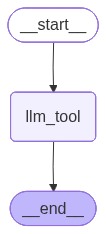

In [181]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [182]:
## invocation

messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (ab71xatev)
 Call ID: ab71xatev
  Args:
    a: 2
    b: 2


| Part                               | Meaning                     |
| ---------------------------------- | --------------------------- |
| `graph.invoke(...)`                | Runs the LangGraph workflow created in step 5 |
| `{"messages": "What is 2 plus 2"}` | Initial user input to graph |
| `messages["messages"]`             | Final conversation history  |
| `pretty_print()`                   | Nicely prints chat          |


# Step 6: Add tools to the graph
this part of the code connects LLM + Tools together in a LangGraph workflow. It decides when to call a tool and when to stop.
Now we let the AI call tools (like the add() function earlier)

In [183]:
tools=[add]

In [184]:
tools

[<function __main__.add(a: int, b: int) -> int>]

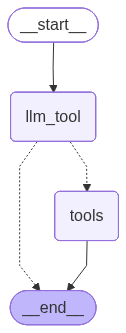

In [185]:

from langgraph.prebuilt import ToolNode, tools_condition
# tools_condition checks:If AI requests a tool → send to tools node If no tool needed → end normally

builder=StateGraph(State) #Starts building a graph using our State (which holds memory of messages).
#State includes messages with a reducer (add_messages) so it stores the whole conversation.

## Add nodes
# First step in graph is always -> go to llm_tool
builder.add_node("llm_tool",llm_tool) # "llm_tool": This is the node where the LLM thinks and may request a tool.
builder.add_node("tools",ToolNode(tools)) # "tools": This node will execute any tool calls that the LLM requests. like tools=[add]

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges("llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition)
builder.add_edge("tools",END)


graph = builder.compile()  # <-- rename to graph
display(Image(graph.get_graph().draw_mermaid_png()))



| Part              | Purpose                                           |
| ----------------- | ------------------------------------------------- |
| ToolNode          | Runs tools like functions (`add`, `search`, etc.) |
| tools_condition   | Routes flow based on tool need                    |
| llm_tool          | LLM thinking node                                 |
| edges             | Define graph flow                                 |
| compile + display | Build and show graph                              |


In [186]:
## invocation

messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (qv2hz180m)
 Call ID: qv2hz180m
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [187]:
messages=graph.invoke({"messages":"what is ai"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is ai
================================== Ai Message ==================================

Artificial intelligence (AI) is a broad field of computer science that involves the creation of intelligent machines that can perform tasks that would typically require human intelligence. This can include tasks such as:

- Learning: AI systems can learn from data and improve their performance over time.
- Problem-solving: AI systems can solve complex problems and make decisions based on data and algorithms.
- Perception: AI systems can interpret and understand data from sensors and other sources.
- Reasoning: AI systems can draw conclusions and make decisions based on data and logic.
- Language understanding: AI systems can understand and generate human language.

AI is a rapidly evolving field that has many applications, including:

- Virtual assistants, such as Siri and Alexa
- Image and speech recognition
- Na

### ✅ Simple Real-Life Example

User: **"What is 2 + 2?"**

LLM (`llm_tool` node) thinks:

* "I need to use `add` tool to solve this."
* Calls: `add(2, 2)`

Graph flow:

```
START → llm_tool → tools → END ✔
```

User: **"Explain Machine Learning."**

LLM doesn’t need tools, so:

```
START → llm_tool → END ✔
```

---

